# Contexto

## Notas del curso: Rudimentos de Machine Learning

## Introducción a Aprendizaje No Supervisado
El aprendizaje no supervisado es una técnica fundamental en el campo de la inteligencia artificial y el aprendizaje automático, donde el objetivo es descubrir patrones ocultos o estructuras intrínsecas en los datos sin necesidad de etiquetas o instrucciones explícitas. A diferencia del aprendizaje supervisado, donde los modelos se entrenan usando datos etiquetados, el aprendizaje no supervisado trabaja con datos que no tienen etiquetas, lo que significa que el sistema intenta aprender la estructura de los datos por sí mismo.

Esta forma de aprendizaje es crucial en situaciones donde recopilar datos etiquetados es demasiado costoso, difícil o impráctico. Permite a los investigadores y a los profesionales hacer frente a una amplia gama de problemas, como la agrupación de clientes con preferencias similares, la detección de anomalías en transacciones financieras o el análisis de grandes volúmenes de datos no estructurados, como textos o imágenes.

Existen varios métodos y algoritmos asociados con el aprendizaje no supervisado, incluyendo el clustering (por ejemplo, K-means, clustering jerárquico), reducción de dimensionalidad (por ejemplo, PCA, t-SNE), y modelos generativos (por ejemplo, autoencoders, GANs). Estos métodos tienen el potencial de revelar insights valiosos y patrones no evidentes a simple vista, impulsando innovaciones y mejorando decisiones en campos como el marketing, la seguridad informática, la genómica, y más allá.

En resumen, el aprendizaje no supervisado representa una herramienta poderosa y versátil en el análisis de datos, ofreciendo la posibilidad de descubrir conocimientos profundos y patrones complejos en grandes conjuntos de datos, todo ello sin la necesidad de intervención o guía humana explícita.

En esta notebook, solo nos concentraremos en reducir la dimensión del dataset con PCA.

## Análisis de Componentes Principales
El Análisis de Componentes Principales (ACP), o Principal Component Analysis (PCA) en inglés, es una técnica de reducción de dimensionalidad que se utiliza frecuentemente en el análisis de datos y en la ciencia de datos para transformar datos multidimensionales en una forma más simplificada, preservando tanto como sea posible la varianza original. La idea clave detrás del ACP es identificar las direcciones, o 'componentes principales', en las que los datos varían más y proyectar los datos originales en un nuevo espacio de dimensiones menores basado en estos componentes, ortogonal al espacio original.



# Import

In [1]:
# Data Analysis
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Statistics
import scipy.stats as stats

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.stats.diagnostic import lilliefors
from statsmodels.multivariate.pca import PCA

# Clustering
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

# Metrics
from sklearn.metrics import silhouette_score

# Funciones

In [2]:
def high_correlation_features(dataframe, threshold=0.95):
    """
    Identifies and returns pairs of highly correlated features from the given dataframe.

    Parameters:
    - dataframe: A pandas DataFrame containing the dataset.
    - threshold: A float representing the correlation threshold to identify high correlations.

    Returns:
    - A DataFrame with pairs of features that have a correlation coefficient above the threshold.
    """
    # Calculate the correlation matrix
    corr_matrix = dataframe.corr()

    # Find features with a correlation above the threshold
    # Note: The matrix is symmetric, so we need to filter out one side to avoid duplicates
    high_corr_pairs = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
                       .stack()
                       .reset_index())
    high_corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
    high_corr_pairs = high_corr_pairs.loc[abs(high_corr_pairs['Correlation']) > threshold, :]

    return high_corr_pairs

In [3]:
def remove_highly_correlated_features(dataframe, threshold=0.95):
    """
    Removes features that are highly correlated with each other above a specified threshold.

    Parameters:
    - dataframe: A pandas DataFrame containing the dataset.
    - threshold: A float representing the correlation threshold to identify high correlations.

    Returns:
    - A DataFrame with the highly correlated features removed.
    """
    # Calculate the correlation matrix
    corr_matrix = dataframe.corr().abs()
    
    # Select upper triangle of correlation matrix
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find features with correlation greater than the threshold
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
    
    # Drop features 
    reduced_df = dataframe.drop(to_drop, axis=1)
    
    return reduced_df, to_drop

In [4]:
def plot_correlation_matrix(dataframe, plot_graph=True, return_matrix=False):
    """
    Calculates and optionally plots the correlation matrix of a given DataFrame.
    
    Parameters:
    - dataframe: DataFrame from which to calculate the correlation matrix.
    - plot_graph: If True, displays a heatmap of the correlation matrix.
    - return_matrix: If True, returns the correlation matrix.
    
    Returns:
    - If return_matrix is True, returns the correlation matrix of the dataframe.
    """
    # Calculate the correlation matrix
    correlation_matrix = dataframe.corr('spearman')
    
    # Plot the correlation matrix heatmap if requested
    if plot_graph:
        plt.figure(figsize=(25, 20))
        sns.heatmap(correlation_matrix, vmin=-1, vmax=1, center=0, cmap="hot", annot=True, fmt=".1f", square=True)
        plt.xticks(rotation=45, horizontalalignment='right')
    
    # Return the correlation matrix if requested
    if return_matrix:
        return correlation_matrix

# Lectura y análisis exploratorio

In [5]:
df = pd.read_csv('./AutoInsurance.csv')
df.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,3/2/2011,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   object 
 1   State                          9134 non-null   object 
 2   Customer Lifetime Value        9134 non-null   float64
 3   Response                       9134 non-null   object 
 4   Coverage                       9134 non-null   object 
 5   Education                      9134 non-null   object 
 6   Effective To Date              9134 non-null   object 
 7   EmploymentStatus               9134 non-null   object 
 8   Gender                         9134 non-null   object 
 9   Income                         9134 non-null   int64  
 10  Location Code                  9134 non-null   object 
 11  Marital Status                 9134 non-null   object 
 12  Monthly Premium Auto           9134 non-null   i

No hay datos faltantes, esto se nota porque todas variables tienen la misma cantidad de registros.

In [7]:
df = df.rename(columns={"Customer Lifetime Value":"Customer_Lifetime_Value","Location Code":"Location_Code","Marital Status":"Marital_Status","Monthly Premium Auto":"Monthly_Premium_Auto","Months Since Last Claim":"Months_Since_Last_Claim",
                           "Months Since Policy Inception":"Months_Since_Policy_Inception","Number of Open Complaints":"Number_of_Open_Complaints","Number of Policies":"Number_of_Policies",
                           "Policy Type":"Policy_Type","Renew Offer Type":"Renew_Offer_Type","Sales Channel":"Sales_Channel","Total Claim Amount":"Total_Claim_Amount",
                           "Vehicle Class":"Vehicle_Class","Vehicle Size":"Vehicle_Size"})

In [8]:
df.describe()

,Customer_Lifetime_Value,Income,Monthly_Premium_Auto,Months_Since_Last_Claim,Months_Since_Policy_Inception,Number_of_Open_Complaints,Number_of_Policies,Total_Claim_Amount
count,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000
mean,8004.940475,37657.380009,93.219291,15.097000,48.064594,0.384388,2.966170,434.088794
std,6870.967608,30379.904734,34.407967,10.073257,27.905991,0.910384,2.390182,290.500092
min,1898.007675,0.000000,61.000000,0.000000,0.000000,0.000000,1.000000,0.099007
25%,3994.251794,0.000000,68.000000,6.000000,24.000000,0.000000,1.000000,272.258244
50%,5780.182197,33889.500000,83.000000,14.000000,48.000000,0.000000,2.000000,383.945434
75%,8962.167041,62320.000000,109.000000,23.000000,71.000000,0.000000,4.000000,547.514839
max,83325.381190,99981.000000,298.000000,35.000000,99.000000,5.000000,9.000000,2893.239678


Revisamos si existen valores duplicados

In [9]:
df[df.duplicated(['Customer'])]

,Customer,State,Customer_Lifetime_Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months_Since_Policy_Inception,Number_of_Open_Complaints,Number_of_Policies,Policy_Type,Policy,Renew_Offer_Type,Sales_Channel,Total_Claim_Amount,Vehicle_Class,Vehicle_Size


In [10]:
#Borro estás variables porque no son necesarias.
df.drop(['Customer','Effective To Date'], axis=1, inplace = True)

No existen clientes duplicados

## Variables categóricas y numéricas

In [11]:
# Detectar características categóricas y numéricas
categorical_features = df.select_dtypes(
    include=["object", "category"]
).columns.tolist()
numerical_features = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

In [12]:
print("Características Numéricas:", numerical_features)

Características Numéricas: ['Customer_Lifetime_Value', 'Income', 'Monthly_Premium_Auto', 'Months_Since_Last_Claim', 'Months_Since_Policy_Inception', 'Number_of_Open_Complaints', 'Number_of_Policies', 'Total_Claim_Amount']


In [13]:
print("Características Categóricas:", categorical_features)

Características Categóricas: ['State', 'Response', 'Coverage', 'Education', 'EmploymentStatus', 'Gender', 'Location_Code', 'Marital_Status', 'Policy_Type', 'Policy', 'Renew_Offer_Type', 'Sales_Channel', 'Vehicle_Class', 'Vehicle_Size']


## Distribución de las variables númericas

In [14]:
colors = ['#028484', '#BA55D3']

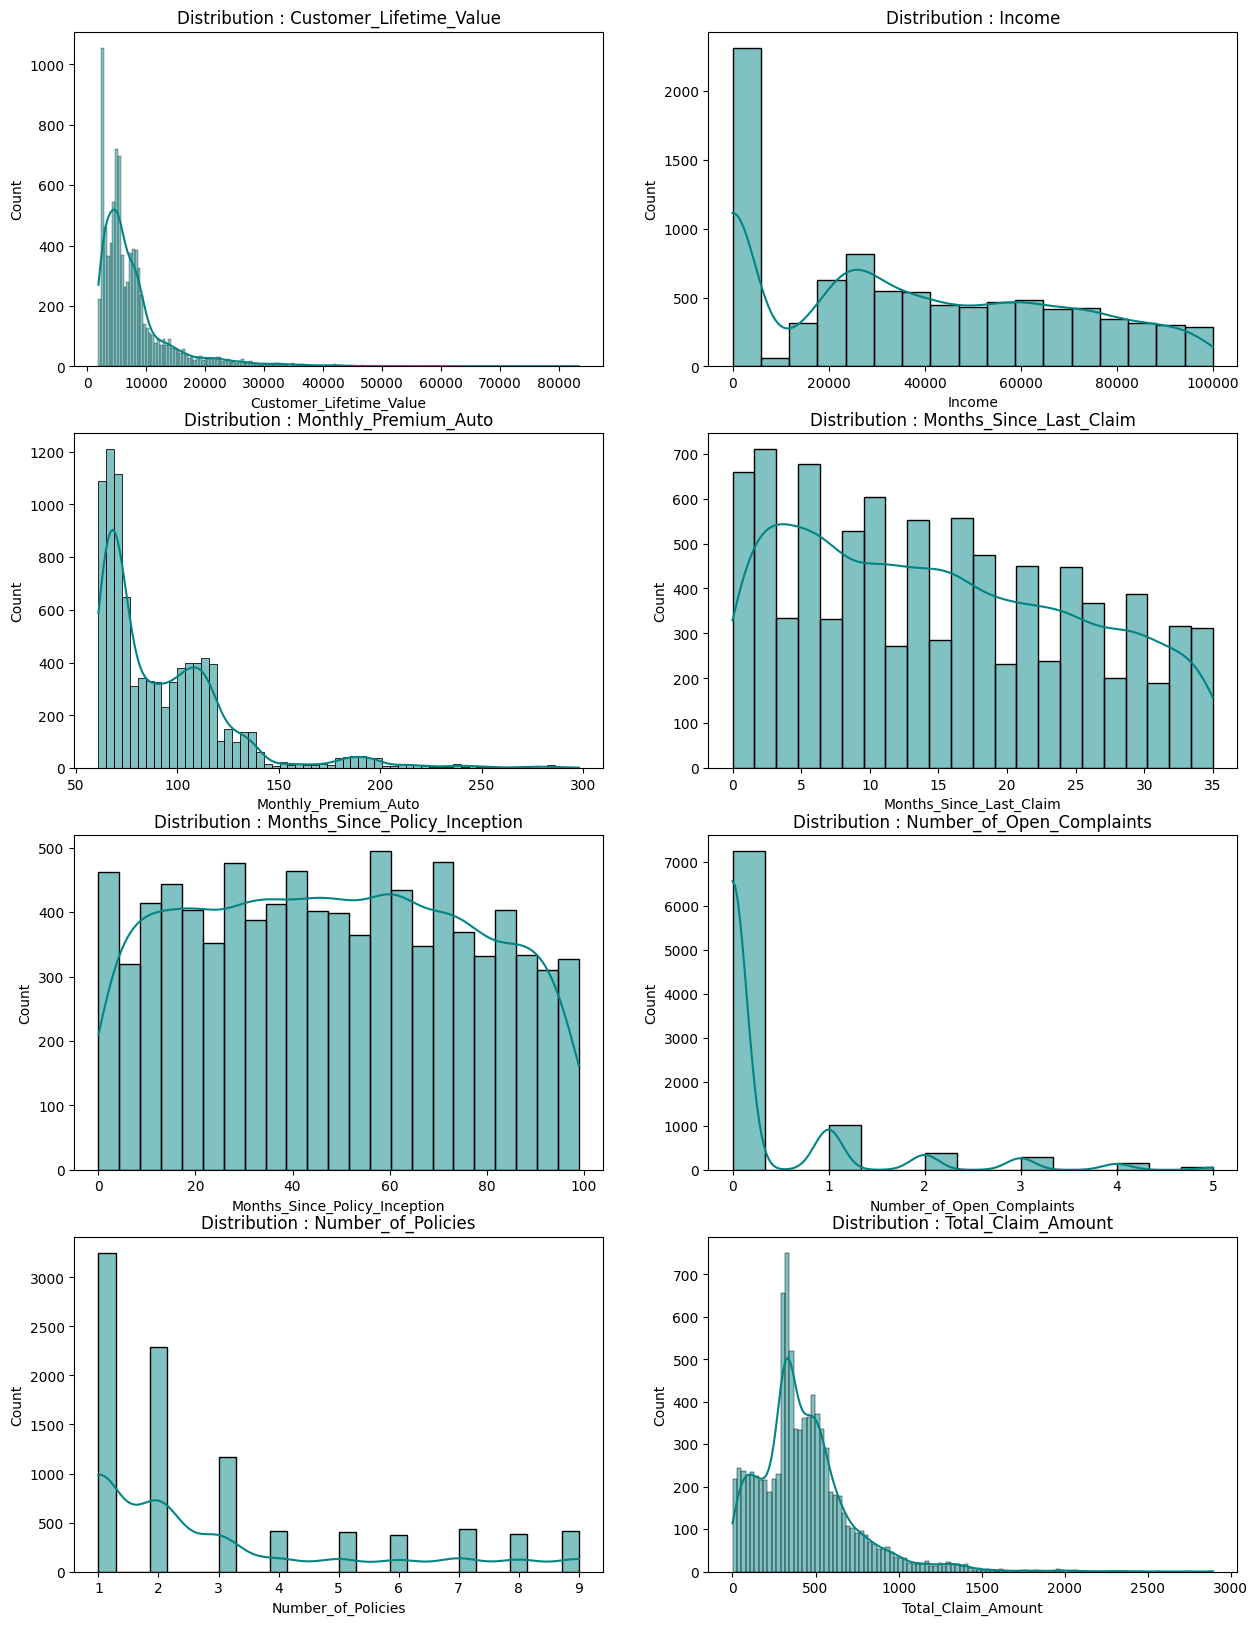

In [15]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))

for i in range(len(numerical_features)):
    plt.subplot(4, 2, i + 1)
    sns.histplot(df[numerical_features[i]], color=colors[0], kde=True)
    title = "Distribution : " + numerical_features[i]
    plt.title(title)
plt.show()

La mayoría de las distribuciones están sesgadas a la derecha, esto en parte porque la mayoría de las variables se tratan de importes o ingresos. Solo hay dos casos en las que esto no es muy claro.

* Months Since Policy Inception: En esa distribucuón vemos que la mayoría de los clientes empiezan a disminuir al final, esto se debe a que en muchos negocios los clientes con mayor antigüedad son minoría. 
* Months Since Last Claim: Esta gráfica es interesante ya que nos revela dos posibles escenarios, los siniestros ocurren en lapsos cortos de tiempo o posiblemente los clientes que tienen un siniestro deciden no renovar su póliza y si este fuera el caso sería interesante evaluar el por qué abandonan a la aseguradora.

Por último podemos notar que existen dos variables que son discretas:
* Number of Open Complaints
* Number of Policies

Esto es correcto ya que no tendría sentido recibir medias reclamaciones o contratar media póliza.

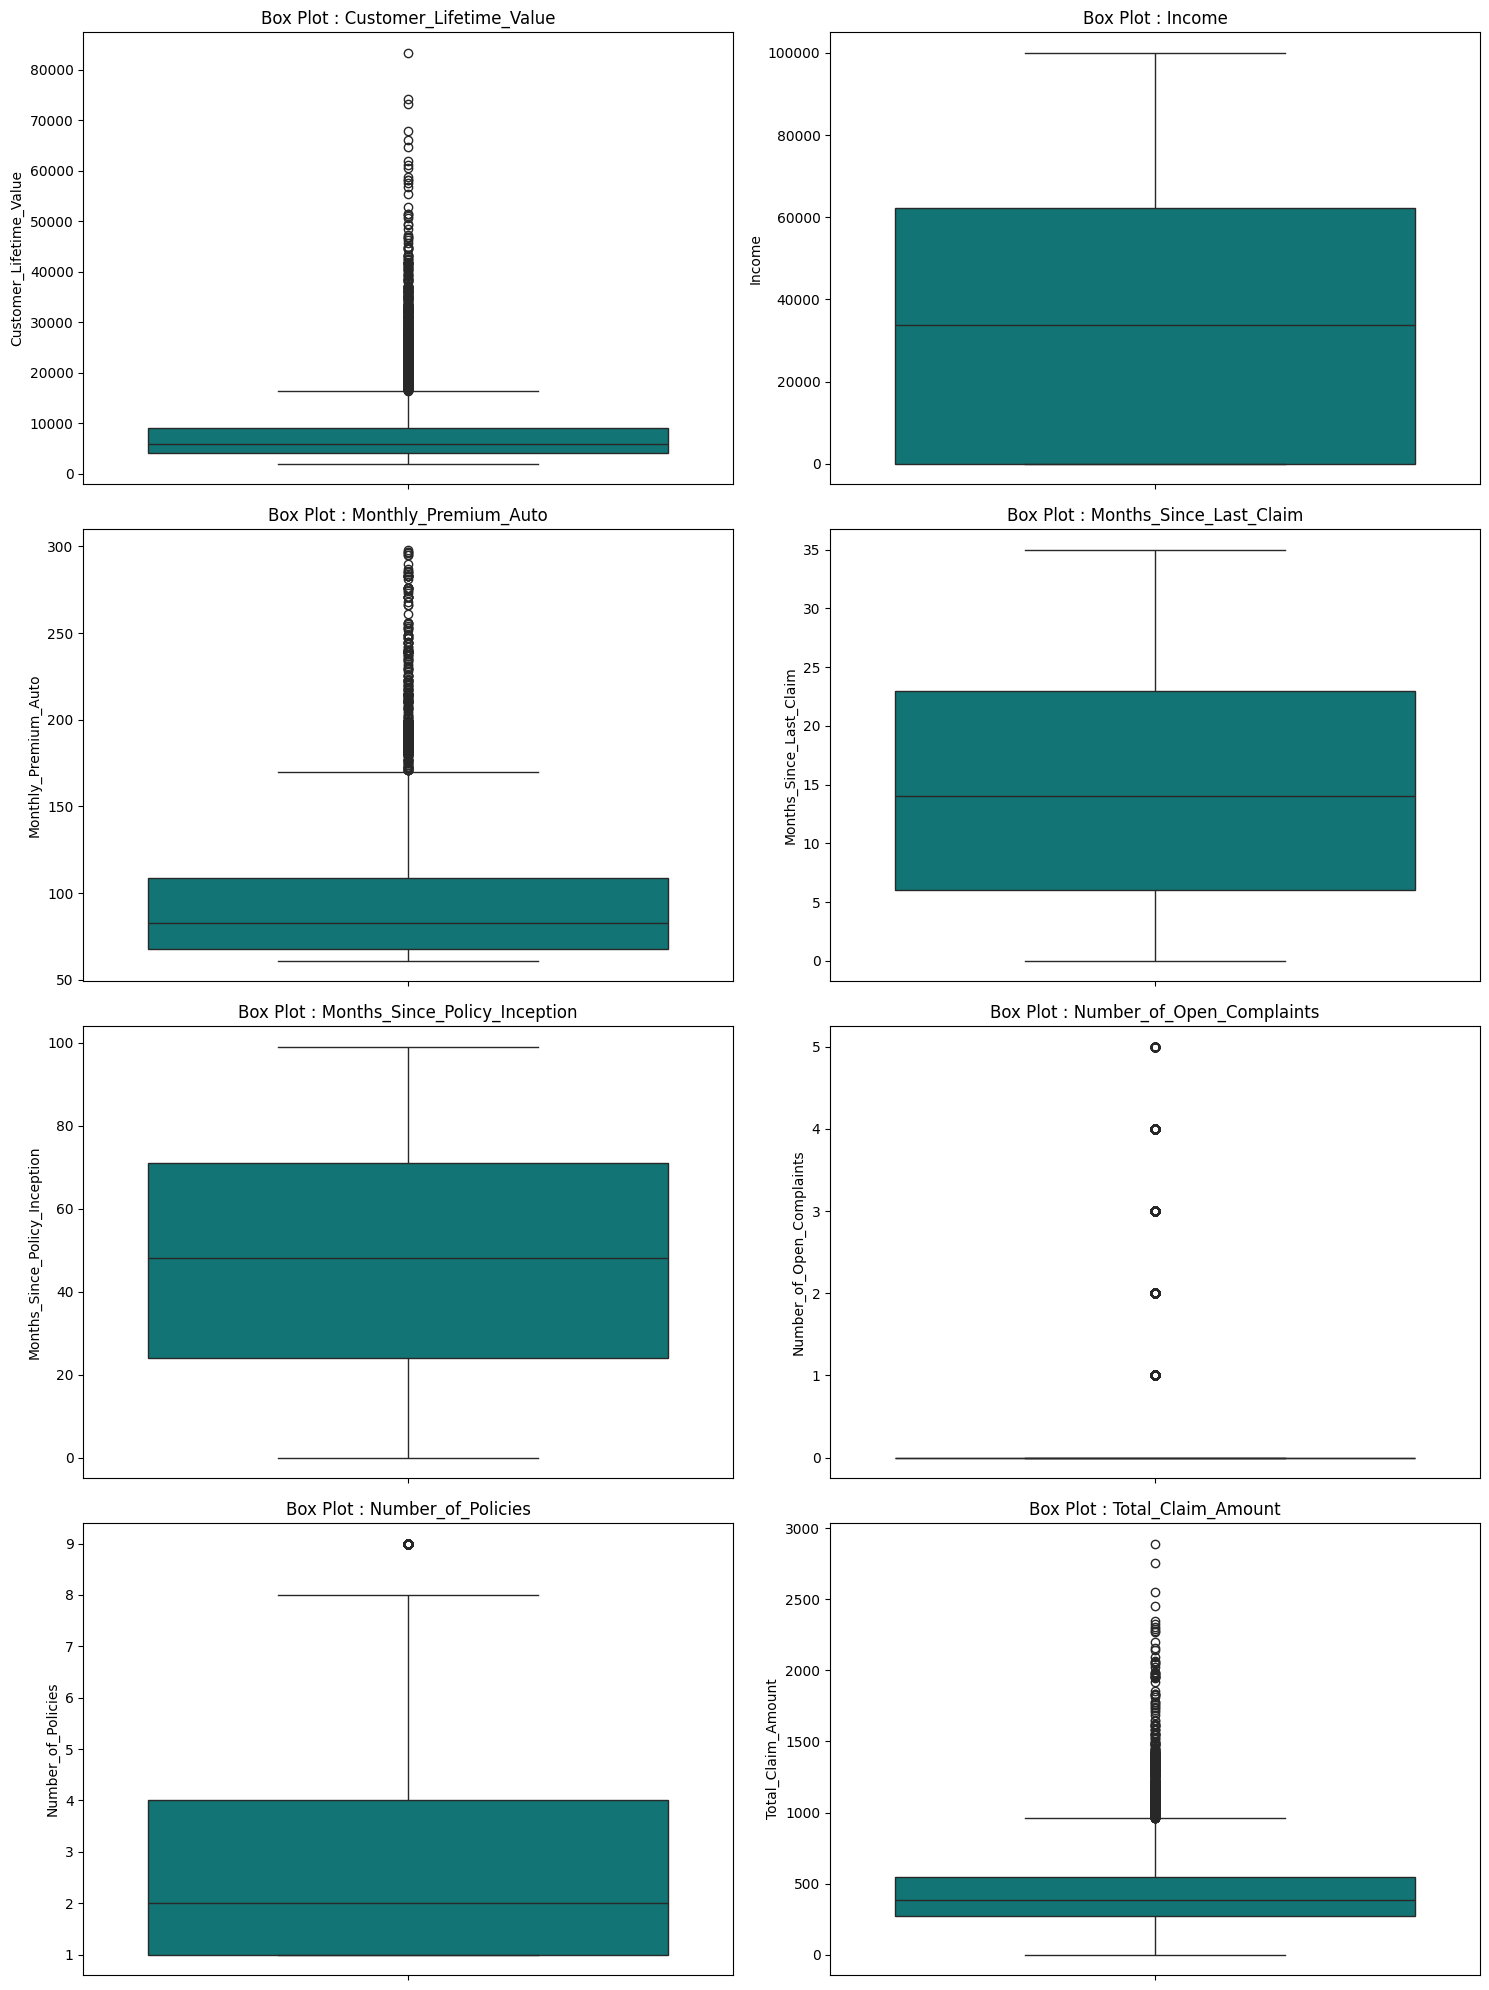

In [16]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))
for i in range(len(numerical_features)):
    plt.subplot(4, 2, i + 1)
    sns.boxplot(data=df[numerical_features[i]], color=colors[0])
    title = "Box Plot : " + numerical_features[i]
    plt.title(title)
plt.tight_layout()
plt.show()

Los conclusiones se mantienen, pero en esta ocasión podemos observar que la variable: Months Since Policy Inception parece tener una distribución normal. La otra variable que parece tener esta distribución es: Months Since Last Claim, pero la descarto porque tiene el brazo superior más alagardo, lo que indica un sesgo como en el resto de las variables.

La normalidad la válidaré usando el gŕafico Q-Q y la prueba de Lilliefors

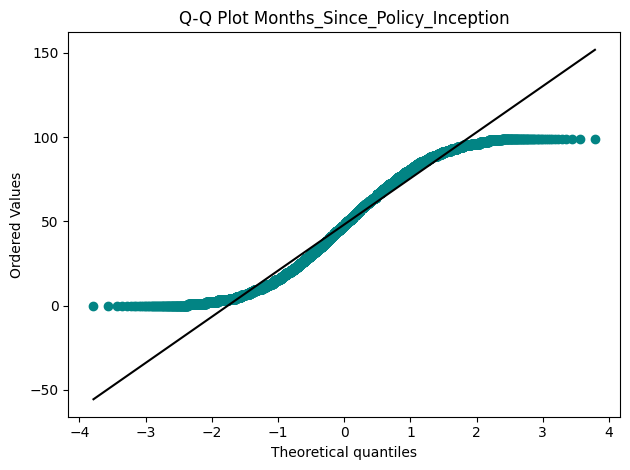

In [17]:
# Generar el gráfico Q-Q plot
stats.probplot(df['Months_Since_Policy_Inception'], plot=plt)
title = 'Q-Q Plot Months_Since_Policy_Inception'
plt.title(title)

# Cambiar el color de las líneas directamente
lines = plt.gca().get_lines()  # Obtener todas las líneas del gráfico actual
lines[0].set_color(colors[0])    # Cambiar el color de la primera línea
lines[1].set_color('black')      # Cambiar el color de la segunda línea (si es necesario)

plt.tight_layout()
plt.show()

In [18]:
n_test = lilliefors(df['Months_Since_Policy_Inception'])
#El segundo valor es el p-value
n_test[1]

0.0009999999999998899

##### Conclusión

* Q-Q plot: la curvatura en los extremos se alejan de las distribución teórica, en este tenemos que la cola inferor en más pesada y la inferior es más ligera.
 
* Lilliefors: Es una prueba robusta para normalidad, la cual tiene como hipótesis nula que la muestra proviene de una distrubición normal, el resultado del p-value indica que la muestra tiene una baja probabilidad de cumplir la hipótesis nula, por lo que la muestra no proviene de una distrubución normal. 

## Variables categorícas

In [19]:
# let's have a look at how many labels for categorical features
for col in categorical_features:
    print(col, ': ', len(df[col].unique()), ' labels')

State :  5  labels
Response :  2  labels
Coverage :  3  labels
Education :  5  labels
EmploymentStatus :  5  labels
Gender :  2  labels
Location_Code :  3  labels
Marital_Status :  3  labels
Policy_Type :  3  labels
Policy :  9  labels
Renew_Offer_Type :  4  labels
Sales_Channel :  4  labels
Vehicle_Class :  6  labels
Vehicle_Size :  3  labels


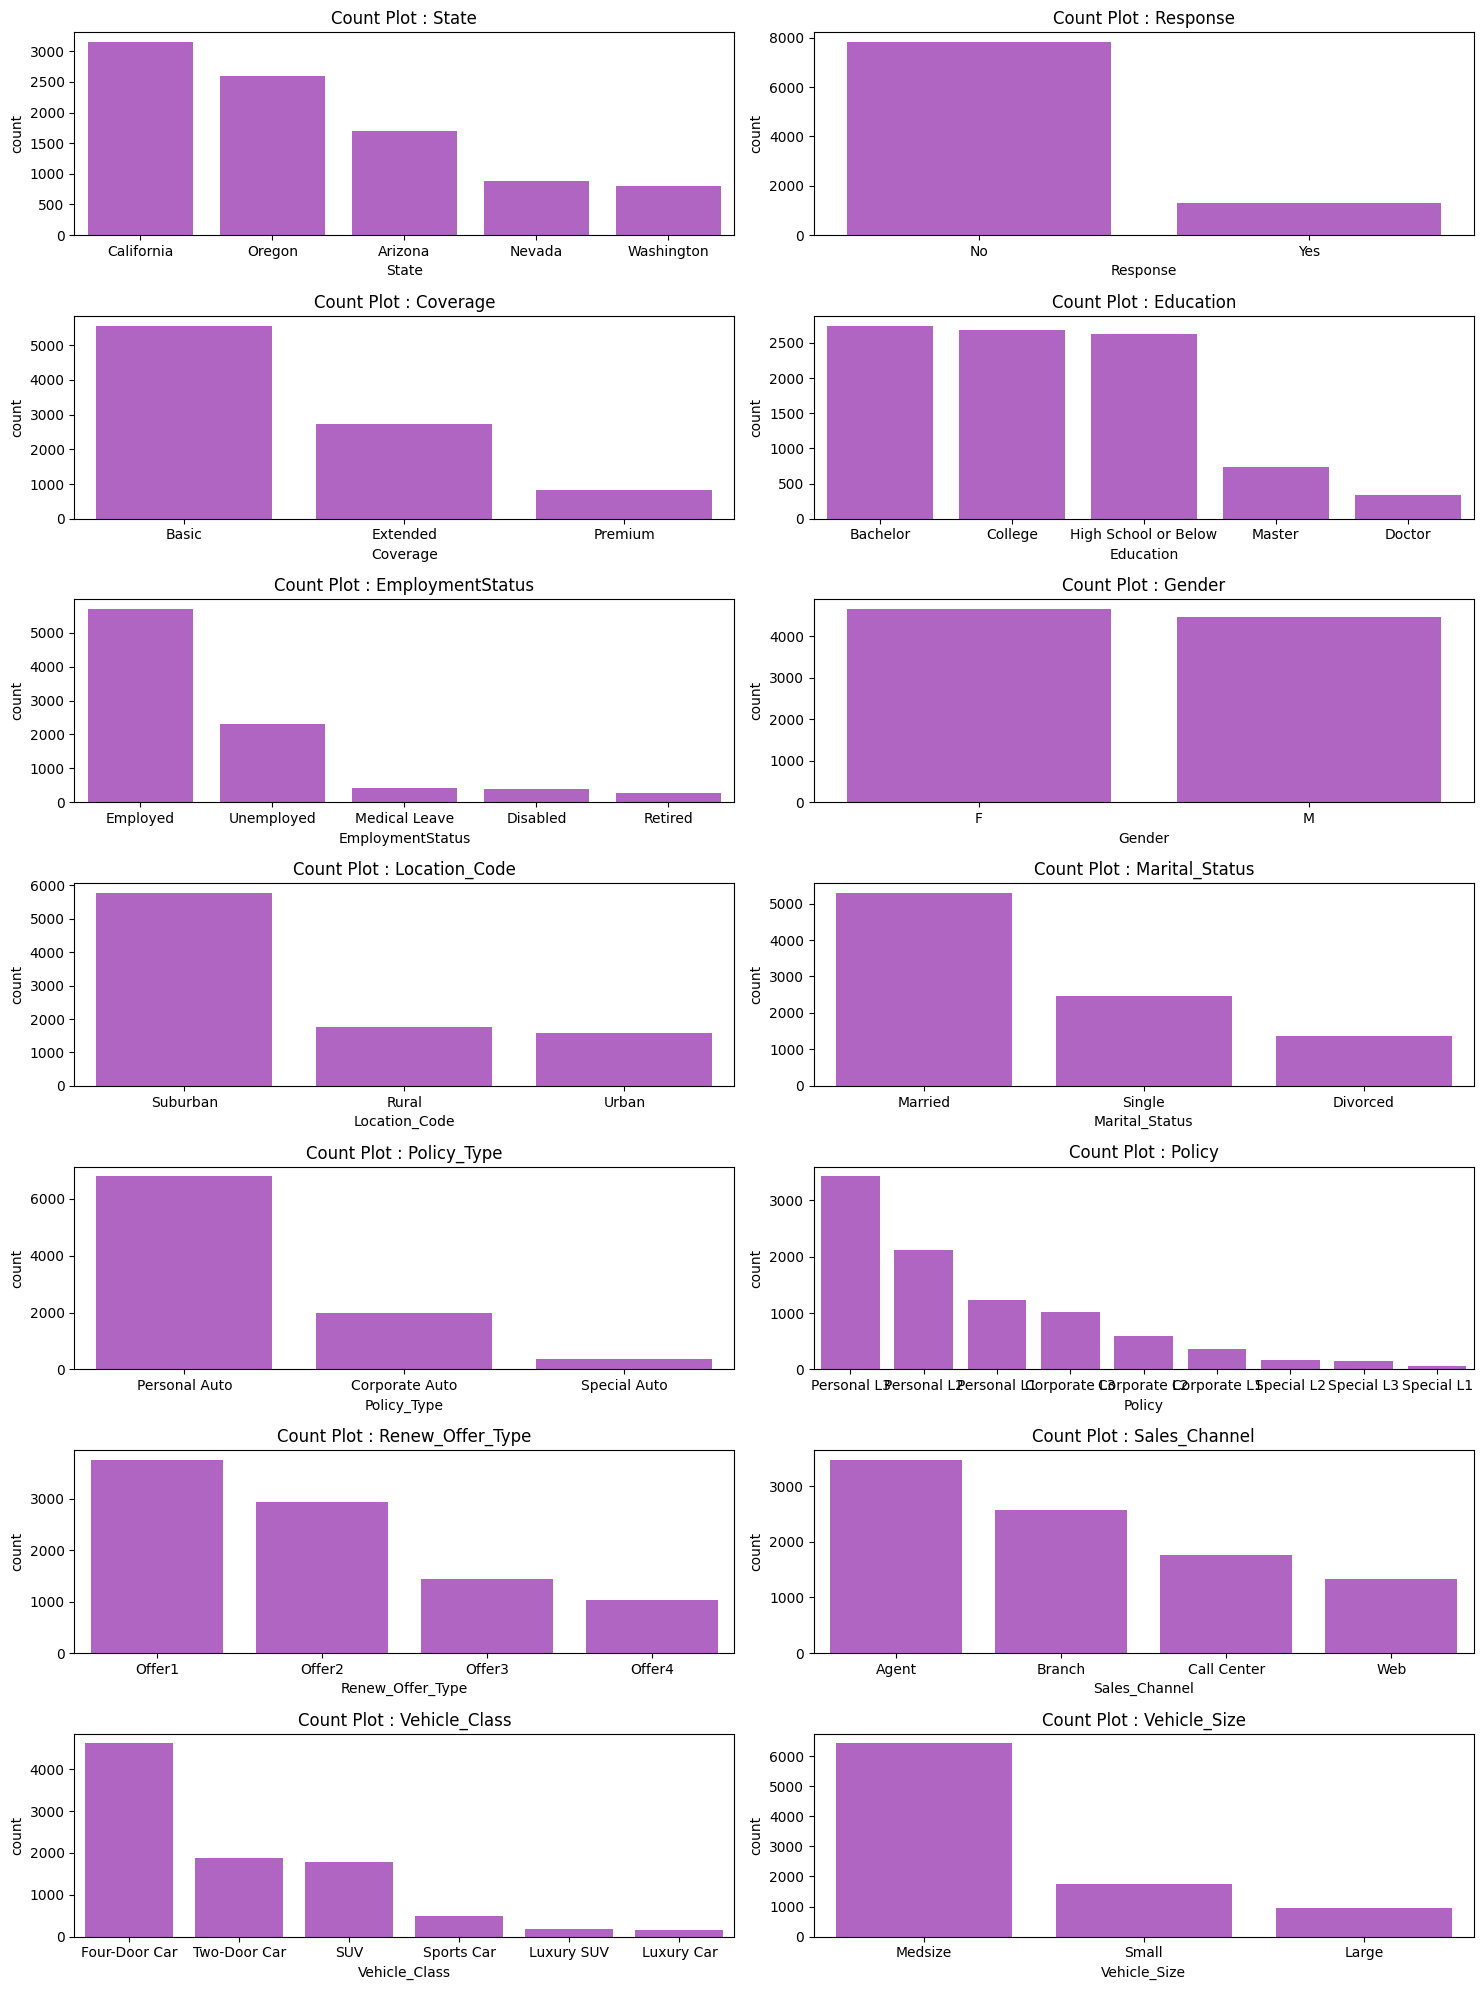

In [20]:
fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(15, 20))
for i in range(len(categorical_features)):
    plt.subplot(7, 2, i + 1)
    sns.countplot(x=df[categorical_features[i]], order=df[categorical_features[i]].value_counts().index, color = colors[1])
    title = "Count Plot : " + categorical_features[i]
    plt.title(title)
plt.tight_layout()
plt.show()

La intención de está gráfica es mostrar los posibles valores y frecuencia de las varibles categorícas. Es decir, es un apoyo visual para identificar variables nóminales y ordinales.

#### Variables ordinales:

* Coverage: Basic, Extended, Premium (si implican un nivel de servicio, pueden ser ordinales)
* Education: High School, Bachelor, Master, Doctorate (podemos suponer un orden natural)
* EmploymentStatus: Unemployed, Employed, Retired (puede ser considerada ordinal si se percibe que el status tiene un orden percibido)
* Renew Offer Type: Offer1, Offer2, Offer3, Offer4 (si están en un secuencia son ordinales)


#### Variables nominales:

* State: Names of states (no hay orden inherente)
* Location Code: Code (no hay orden)
* Response: Yes, No (binaria, no hay orden)
* Gender: Male, Female (binaria, no hay orden)
* Policy Type: Corporate Auto, Personal Auto (no hay orden inherente)
* Policy: Corporate L1, Corporate L2, Corporate L3, Personal L1, Personal L2, Personal L3 (no hay orden inherente)
* Sales Channel: Agent, Call Center, Web, Branch (no hay orden inherente)
* Vehicle Class: Two-Door Car, Four-Door Car, SUV (no hay orden inherente)
* Vehicle Size: Small, Medsize, Large (podría considerarse ordenada)
* Marital Status: Single, Married, Divorced (no hay orden)

# Preprocesamiento

In [21]:
# Defining the ordinal and nominal categorical variables
ordinal_columns = ['Coverage', 'Education', 'EmploymentStatus', 'Renew_Offer_Type']
nominal_columns = ['State', 'Location_Code', 'Marital_Status', 'Response', 'Gender', 'Policy_Type', 'Policy', 'Sales_Channel', 'Vehicle_Class', 'Vehicle_Size']

In [22]:
# Define the order for the ordinal columns
ordinal_categories = {
    'Coverage': ['Basic', 'Extended', 'Premium'],
    'Education': ['High School or Below', 'Bachelor', 'Master', 'Doctorate'],
    'EmploymentStatus': ['Unemployed', 'Employed', 'Retired'],
    'Renew_Offer_Type': ['Offer1', 'Offer2', 'Offer3', 'Offer4']
}

In [23]:
#Transform nominal columns
data = pd.get_dummies(df, columns=nominal_columns)
data

,Customer_Lifetime_Value,Coverage,Education,EmploymentStatus,Income,Monthly_Premium_Auto,Months_Since_Last_Claim,Months_Since_Policy_Inception,Number_of_Open_Complaints,Number_of_Policies,...,Sales_Channel_Web,Vehicle_Class_Four-Door Car,Vehicle_Class_Luxury Car,Vehicle_Class_Luxury SUV,Vehicle_Class_SUV,Vehicle_Class_Sports Car,Vehicle_Class_Two-Door Car,Vehicle_Size_Large,Vehicle_Size_Medsize,Vehicle_Size_Small
0,2763.519279,Basic,Bachelor,Employed,56274,69,32,5,0,1,...,False,False,False,False,False,False,True,False,True,False
1,6979.535903,Extended,Bachelor,Unemployed,0,94,13,42,0,8,...,False,True,False,False,False,False,False,False,True,False
2,12887.431650,Premium,Bachelor,Employed,48767,108,18,38,0,2,...,False,False,False,False,False,False,True,False,True,False
3,7645.861827,Basic,Bachelor,Unemployed,0,106,18,65,0,7,...,False,False,False,False,True,False,False,False,True,False
4,2813.692575,Basic,Bachelor,Employed,43836,73,12,44,0,1,...,False,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9129,23405.987980,Basic,Bachelor,Employed,71941,73,18,89,0,2,...,True,True,False,False,False,False,False,False,True,False
9130,3096.511217,Extended,College,Employed,21604,79,14,28,0,1,...,False,True,False,False,False,False,False,False,True,False
9131,8163.890428,Extended,Bachelor,Unemployed,0,85,9,37,3,2,...,False,True,False,False,False,False,False,False,True,False
9132,7524.442436,Extended,College,Employed,21941,96,34,3,0,3,...,False,True,False,False,False,False,False,True,False,False


In [24]:
# Transforming ordinal columns
for column, categories in ordinal_categories.items():
    data[column] = data[column].astype(pd.CategoricalDtype(categories=categories, ordered=True)).cat.codes

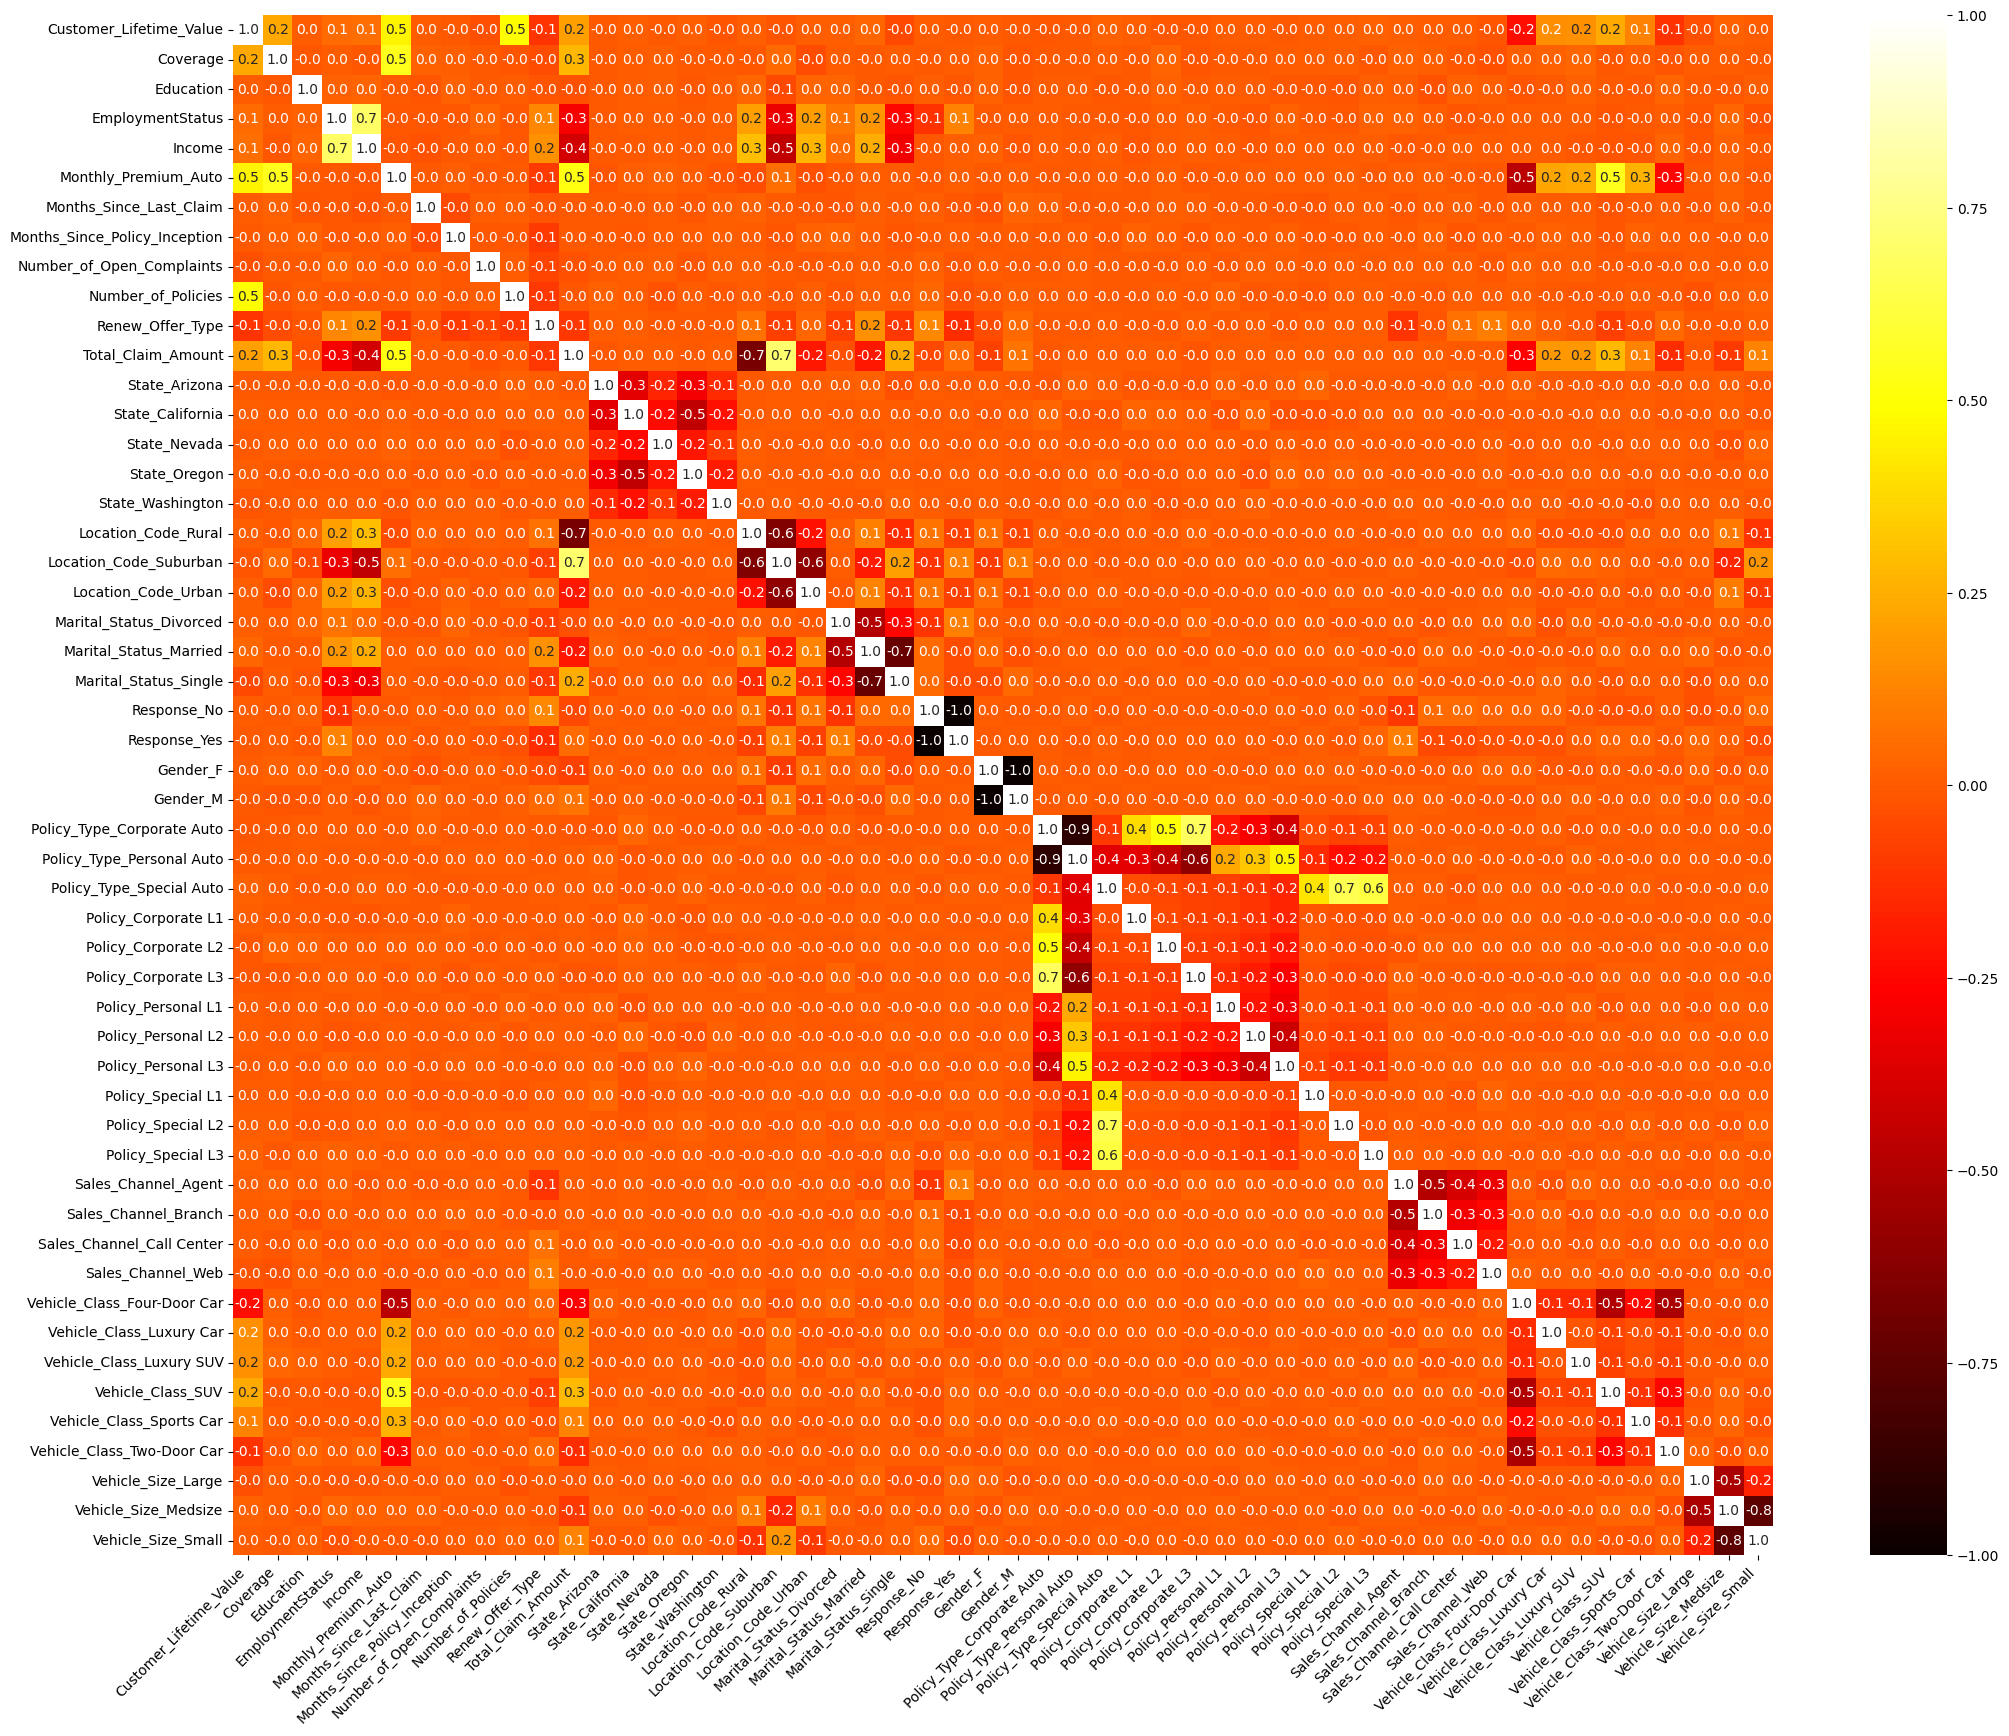

In [25]:
plot_correlation_matrix(data, plot_graph=True, return_matrix=False)

In [26]:
high_correlation_features(data, threshold=0.95)

,Feature 1,Feature 2,Correlation
920,Response_No,Response_Yes,-1.0
975,Gender_F,Gender_M,-1.0



Se observan variables correlacionadas, pero solo sobresalen las que en este contexto son complemento, por ese motivo tienen una relación perfecta negativa.

# Reducción de la dimensionalidad

In [27]:
data.shape

(9134, 52)

## PCA

In [28]:
pca_2Dmodel = PCA(data, ncomp=2, standardize=True, normalize=False)
pca_2Dmodel.factors

,comp_0,comp_1
0,-0.963483,3.128291
1,2.238018,-1.091758
2,0.573275,-1.115419
3,1.343074,3.145422
4,-1.552583,-0.925460
...,...,...
9129,-2.162068,-0.940872
9130,0.215889,3.371381
9131,1.970591,3.161693
9132,0.661863,-0.905744


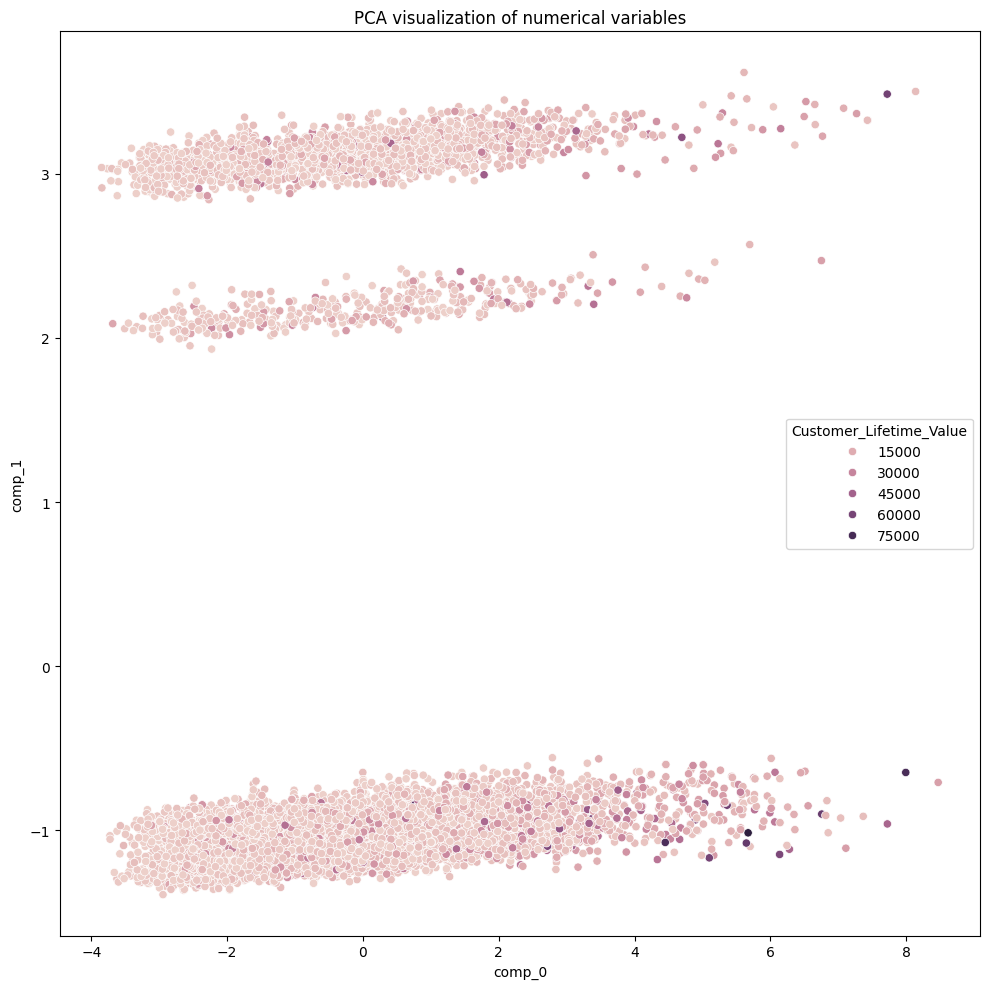

In [29]:
dff = pd.concat([data['Customer_Lifetime_Value'], pca_2Dmodel.factors], axis=1)
# Show the diagram
fig = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=dff, x='comp_0',y='comp_1',hue='Customer_Lifetime_Value')
plt.title('PCA visualization of numerical variables')
plt.tight_layout()
plt.show()

#### Pregunta: ¿Qué número de clústers propongo usando la visualización?

Es posible que 2 clusters sean suficientes, aunque en los extremos los puntos son más dispersos, talvez encontrar una delta adecuada para que idéntifique a los puntos dispersos.

## Clustering con K-Means

**K-Means Clustering** es un algoritmo basado en la distancia que se utiliza para el aprendizaje no supervisado que **no admite características categóricas**.

* Es un algoritmo muy utilizado para tratar con **Aprendizaje no supervisado** que hace el trabajo de encontrar clusters en los datos pero con un enfoque matemático:
    - Selecciona 2 (supongamos k = 2) centroides al azar.
    - Se calcula la distancia entre los centroides y todos los puntos de datos.
    - Si el punto de datos está más cerca de uno de los centroides, entonces se etiqueta como ese centroide y viceversa.
    - Para los 2 conglomerados formados, se calcula el valor medio de los puntos de datos agrupados con cualquiera de los centroides y estos valores medios se definen como los nuevos conglomerados.
    - Este proceso se repite hasta que ambos centroides convergen en puntos fijos.

* hiperparámetro **k** : Define el número de conglomerados o grupos en que se dividirán los datos. Para la selección de los valores de **k**, utilizamos 2 pruebas estadísticas :
    - **Método del arco** : Es un método que representa gráficamente la suma del error cuadrático para un intervalo de valores de **k**. Si este gráfico se parece a un brazo, entonces **k** es el valor que se parece a un **codo** es seleccionado. A partir de este valor de **codo**, la suma de valores al cuadrado (inercia) empieza a disminuir de forma lineal y, por tanto, se considera un valor óptimo.
    - **Método de la puntuación de la silueta** : Se trata de un método que evalúa la calidad de los conglomerados en función del grado de agrupación de los puntos de datos con otros puntos de datos similares.

In [30]:
scaler = StandardScaler()
data_std = scaler.fit_transform(data)

In [31]:
sse = {}
sil = []
kmax = 10

for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init='auto', algorithm='lloyd').fit(data_std)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    labels = kmeans.labels_
    sil.append(silhouette_score(data_std, labels, metric = 'euclidean'))

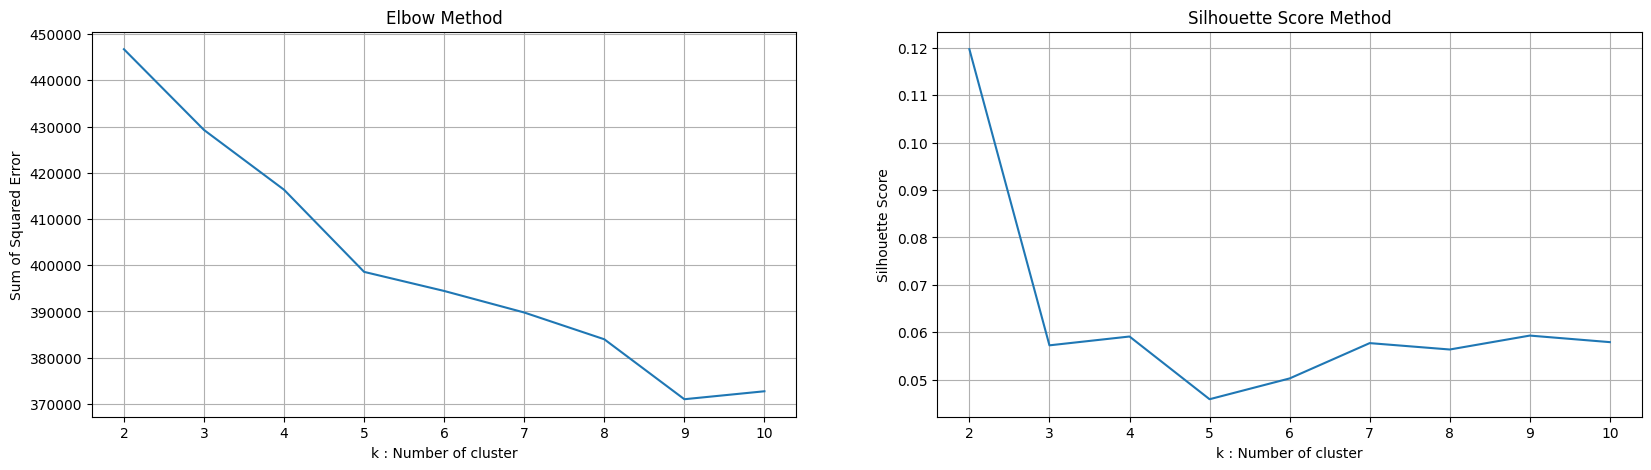

In [32]:
fig = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))

# Elbow Method : Sum of Squared Error
plt.subplot(1,2,1)
sns.lineplot(x = list(sse.keys()), y = list(sse.values()))
plt.title('Elbow Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Sum of Squared Error")
plt.grid(True)

# Silhouette Score Method
plt.subplot(1,2,2)
sns.lineplot(x = range(2,kmax + 1), y = sil)
plt.title('Silhouette Score Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

In [33]:
kmeans = KMeans(n_clusters=2, init='k-means++',n_init='auto', algorithm='lloyd').fit(data_std)
labels = kmeans.predict(data_std)

In [34]:
cluster_num = data.copy()
cluster_num['kmeans_cluster'] = labels
cluster_num['kmeans_cluster'].value_counts()

kmeans_cluster
0    6788
1    2346
Name: count, dtype: int64

In [35]:
#print the silhouette score
print(f"Para K-Means: {silhouette_score(data_std, labels, metric = 'euclidean')}")

Para K-Means: 0.11965748269386789


In [36]:
dff_km = pd.concat([cluster_num['kmeans_cluster'], pca_2Dmodel.factors], axis=1)

In [37]:
# Extract cluster centers
centroids = kmeans.cluster_centers_
# Extract the PCA loadings (components)
pca_2Dloadings = pca_2Dmodel.loadings.values
# Transform the standardized centroids using PCA loadings
centroids_2Dpca = centroids @ pca_2Dloadings

In [38]:
# Extract cluster centers
centroids = kmeans.cluster_centers_
# Extract the PCA loadings (components)
pca_2Dloadings = pca_2Dmodel.loadings.values
# Transform the standardized centroids using PCA loadings
centroids_2Dpca = centroids @ pca_2Dloadings

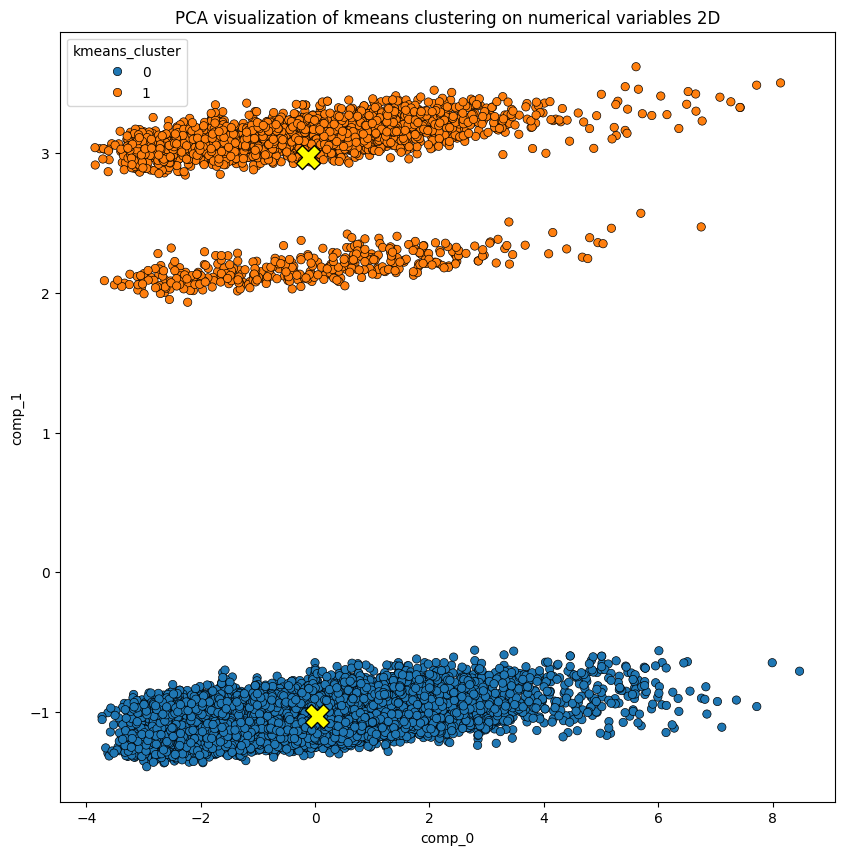

In [39]:
# Show the diagram
fig = plt.subplots(figsize=(10, 10))
sns.scatterplot(x='comp_0', y='comp_1', hue='kmeans_cluster', data=dff_km, edgecolor="black")

# Add centroids to the scatter plot
plt.scatter(centroids_2Dpca[:, 0], centroids_2Dpca[:, 1], s=300, c='yellow', marker='X', edgecolor='black', label='Centroids')
plt.title('PCA visualization of kmeans clustering on numerical variables 2D')
plt.show()

## DBSCAN: Density Based Spatial Clustering of Application with Noise Clustering

**DBSCAN Clustering** es un algoritmo de clustering basado en la densidad que se utiliza para problemas de aprendizaje no supervisado.
- En un intento de eliminar los problemas de **K-Means Clustering** con datos anidados y datos de alta dimensión, **DBSCAN Clustering** ¡los elimina! Tiene 3 términos y 2 hiperparámetros importantes:
    - Términos :
        - **Punto central** : Es el punto central que tiene **minPts** número de puntos de datos presentes en su área y los puntos bajo su área pueden extender el cluster.
        - **Punto no central** : Es el punto central que no tiene **minPts** número de puntos de datos presentes en su área y no puede extender el cluster.
        - **Outliers / Ruido** : Son los puntos de datos que no forman parte de ningún cluster.
    - Hiperparámetros :
        - **minPts** : Es el número mínimo de puntos de datos que deben estar presentes en el área de un punto para ser considerado como un punto central.
        - **Épsilon** : Es el radio del área de un punto central.
- **DBSCAN Clustering** crea los clusters de la siguiente manera :        
    - Seleccionar un punto al azar y considerarlo como punto central a partir de los datos. 
    - Compruebe los otros puntos de datos que se presentan en el área de este punto central con el valor **Epsilon** como su radio.
    - Si esta área tiene **minPts** número de puntos de datos en ella, entonces el punto central se considera como un **punto central**.
    - Los puntos de datos de esta zona se consideran **puntos centrales** que se amplían con las mismas reglas creando un conglomerado. 
    - Si alguno de los puntos no cumple las reglas, se considera un **punto no central** que sigue formando parte del conglomerado, pero no puede ampliarlo más.
    - Cuando todos los **puntos centrales** terminan de englobar a los demás puntos de datos, se incluyen los **puntos no centrales** y se completa el cluster.
    - El siguiente cluster comienza a formarse siguiendo las mismas reglas. Algunos de los puntos no forman parte de ninguno de los clusters, estos puntos se conocen como **outliers / ruido**.
- Como se habrá dado cuenta, los hiperparámetros desempeñan un papel crucial en este proceso. Por lo tanto, tienen ciertas reglas para asignarles valores :
    - **minPts** : Si D representa el número de dimensiones / características de un conjunto de datos, entonces **minPts** >= D + 1. Normalmente, **minPts** >= 2 * D se selecciona para conjuntos de datos más pequeños o ruidosos. 
    - **Épsilon** : Su valor suele decidirse utilizando el gráfico de distancia **k** que se determina a partir del modelo **KNN**. Se selecciona el valor en el que el gráfico cambia bruscamente.

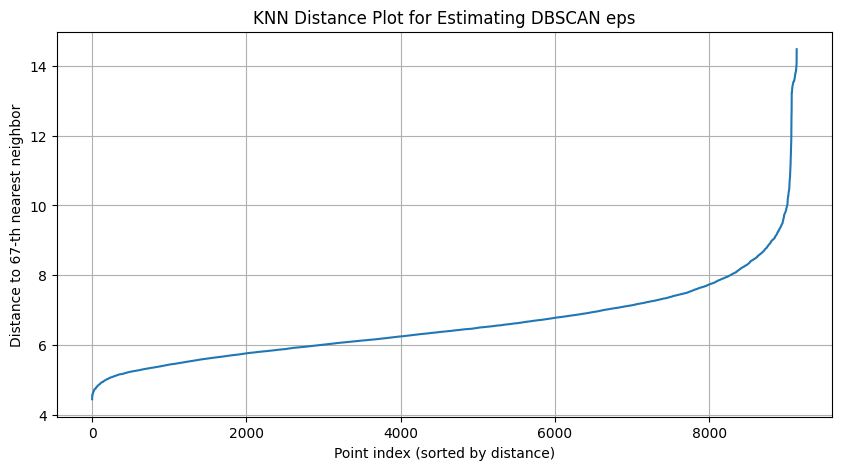

In [40]:
# Using NearestNeighbors to find the distance to the k-th nearest neighbor
k = 67 # As suggested for min_samples in DBSCAN
nn = NearestNeighbors(n_neighbors=k)
nn.fit(data_std)
distances, indices = nn.kneighbors(data_std)

# Sorting the distances
sorted_distances = np.sort(distances[:, k-1], axis=0)

# Plotting the KNN distance plot
plt.figure(figsize=(10, 5))
plt.plot(sorted_distances)
plt.grid(True)
plt.title('KNN Distance Plot for Estimating DBSCAN eps')
plt.xlabel('Point index (sorted by distance)')
plt.ylabel(f'Distance to {k}-th nearest neighbor')
plt.show()

In [41]:
db = DBSCAN(min_samples=67, eps=8.5).fit(data_std)
labels = db.labels_

In [42]:
#print the silhouette score
print(f"Para DBSCAN: {silhouette_score(data_std, labels, metric = 'euclidean')}")

Para DBSCAN: 0.26443857964430556


In [43]:
# Number of clusters in labels, ignoring noise if present
#n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_ = 2
n_noise_ = list(labels).count(-1)
print('Number of Clusters : ', n_clusters_)
print('Number of Outliers : ', n_noise_)

Number of Clusters :  2
Number of Outliers :  95


In [44]:
cluster_num = data.copy()
cluster_num['dbscan_cluster'] = labels
cluster_num['dbscan_cluster'].value_counts()

dbscan_cluster
 0    8740
 1     157
 2     142
-1      95
Name: count, dtype: int64

In [45]:
# Compute pseudo-centroids (mean of points in each cluster)
pseudo_centroids = np.array([data_std[labels == label].mean(axis=0) for label in np.unique(labels) if label != -1])

In [46]:
pseudo_centroids_2Dpca = pseudo_centroids @  pca_2Dloadings 

In [47]:
dff_db = pd.concat([cluster_num['dbscan_cluster'], pca_2Dmodel.factors], axis=1)

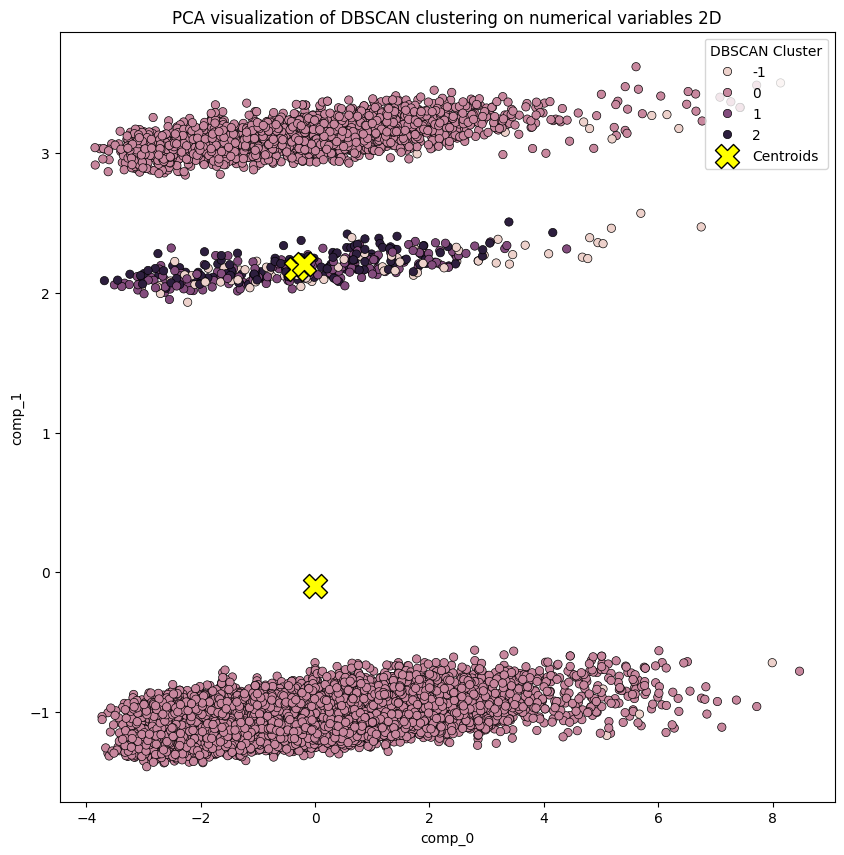

In [48]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x='comp_0', y='comp_1', hue='dbscan_cluster', data=dff_db, edgecolor="black")
plt.scatter(pseudo_centroids_2Dpca[:, 0], pseudo_centroids_2Dpca[:, 1], s=300, c='yellow', marker='X', edgecolor='black', label='Centroids')

plt.legend(title='DBSCAN Cluster', loc='upper right')
plt.title('PCA visualization of DBSCAN clustering on numerical variables 2D')
plt.show()

K-Means y DBSCAN son algoritmos de clustering con enfoques diferentes y, por lo tanto, tienen fortalezas y debilidades distintas en diferentes situaciones.

Aquí hay algunas razones por las cuales K-Means podría ser mejor que DBSCAN en ciertos casos:

* Forma de los Clústeres: K-Means tiende a producir clústeres de forma convexa debido a su enfoque de minimización de la suma de cuadrados de las distancias al cuadrado. Si los clústeres en tus datos tienen formas bien definidas y son aproximadamente esféricos, K-Means podría funcionar mejor.

* Tamaño Uniforme de los Clústeres: K-Means intenta dividir el conjunto de datos en un número predeterminado de clústeres de aproximadamente igual tamaño. Si tus datos tienen clústeres de tamaño similar y deseas una partición clara del espacio de características en un número específico de clústeres, K-Means podría ser más adecuado.

* Eficiencia Computacional: K-Means es computacionalmente más eficiente que DBSCAN, especialmente en conjuntos de datos grandes. DBSCAN puede volverse computacionalmente costoso en conjuntos de datos de alta dimensionalidad debido a la necesidad de calcular la distancia entre cada par de puntos.

* Fácil Implementación y Interpretación: K-Means es más simple de entender e implementar en comparación con DBSCAN. Tiene menos hiperparámetros para ajustar y es más fácil de interpretar los resultados.

Sin embargo, DBSCAN puede ser más apropiado en ciertos escenarios:

* Clústeres de Densidad Variable: DBSCAN puede identificar clústeres de cualquier forma y tamaño y es robusto ante la presencia de ruido y clústeres de densidad variable.

* Clústeres de Forma Arbitraria: Si los clústeres en tus datos tienen formas no convexas o están muy juntos, DBSCAN puede ser más efectivo que K-Means.

* Identificación de Ruido: DBSCAN tiene la capacidad de identificar puntos atípicos o ruido en tus datos como puntos que no pertenecen a ningún clúster.

En resumen, la elección entre K-Means y DBSCAN depende de la naturaleza de tus datos, la forma y densidad de los clústeres que estás tratando de identificar, así como de tus objetivos específicos de clustering. Es importante probar ambos algoritmos y evaluar su rendimiento en función de métricas relevantes y la interpretación de los resultados en el contexto de tu problema específico.